In [1]:
import pandas as pd
import numpy as np
import missingno as msno

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# On charge nos deux jeux de données
df_test = pd.read_csv('application_test.csv')
df = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
ccb = pd.read_csv('credit_card_balance.csv')
install_pay = pd.read_csv('installments_payments.csv')
pos_cash = pd.read_csv('POS_CASH_balance.csv')
prev_app = pd.read_csv('previous_application.csv')

# Fonctions

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## Application (1/6)

In [4]:
df.shape

(307511, 122)

In [5]:
df_cols_drop = ['REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION','DAYS_ID_PUBLISH',
                'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
                'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
                'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
                'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
                'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
                'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
                'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
                'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
                'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
                'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
                'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
                'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
                'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

df_cols_voir = ['NAME_TYPE_SUITE', 'CNT_CHILDREN', 'AMT_GOODS_PRICE','NAME_FAMILY_STATUS', 'OWN_CAR_AGE',
               'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
               'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
               'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
               'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
               'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
               'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
               'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
               'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
               'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
               'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

# On supprime les colonnes qui ne nous intéressent pas
df = df.drop(columns = df_cols_drop)
df_test = df_test.drop(columns = df_cols_drop)

# Pour l'instant on supprime les colonnes où on ne sait pas trop
df = df.drop(columns = df_cols_voir)
df_test = df_test.drop(columns = df_cols_voir)

# Taille des jeux de données après les changements
df.shape

(307511, 18)

In [6]:
# Read data and merge
print("Taille Train: {}, taille test: {}".format(len(df), len(df_test)))
df = df.append(df_test).reset_index()

# On append train et test pour faire les mêmes preprocessing
# On les redivise après

# Optional: Remove 4 applications with XNA CODE_GENDER (train set)
df = df[df['CODE_GENDER'] != 'XNA']

# Categorical features with Binary encode (0 or 1; two categories)
for binary_feat in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[binary_feat], uniques = pd.factorize(df[binary_feat])

# Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df, nan_as_category=False)

# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

# Taux d'endettement plutôt ?
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['CREDIT_INCOME_PERC'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'] # Taux d'endettement

df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

Taille Train: 307511, taille test: 48744


In [7]:
df.isnull().sum()

index                      0
SK_ID_CURR                 0
TARGET                 48744
CODE_GENDER                0
FLAG_OWN_CAR               0
                       ...  
INCOME_CREDIT_PERC         0
CREDIT_INCOME_PERC         0
INCOME_PER_PERSON          2
ANNUITY_INCOME_PERC       36
PAYMENT_RATE              36
Length: 116, dtype: int64

In [9]:
df_nan = df.isnull().mean()
df_nan = df_nan.sort_values(ascending=False)
liste_nan = []

for x, y in zip(df_nan.index, df_nan):
    liste_nan.append((x, y))

liste_nan[:10]

In [12]:
cols = ['DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'AMT_ANNUITY',
        'PAYMENT_RATE', 'ANNUITY_INCOME_PERC', 'INCOME_PER_PERSON',
        'CNT_FAM_MEMBERS']

for col in cols:
    df[col] = df[col].fillna(df[col].median())

## Bureau & bureau_balance (2/6)

In [13]:
# Pas de col à supprimer a priori
# bb_cols_drop = []

bb_cols_voir = ['CREDIT_CURRENCY', 'DAYS_CREDIT_UPDATE', 'DAYS_ENDDATE_FACT']

# Pour l'instant on supprime les colonnes où on ne sait pas trop
# bureau = bureau.drop(columns = bb_cols_drop)
bureau = bureau.drop(columns = bb_cols_voir)

In [14]:
bureau_balance, bb_cat = one_hot_encoder(bureau_balance, nan_as_category=True)
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)
    
# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    
# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
# 'DAYS_CREDIT_UPDATE': ['mean'],

# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

In [15]:
bureau_agg.isnull().sum()

BURO_DAYS_CREDIT_MIN                    0
BURO_DAYS_CREDIT_MAX                    0
BURO_DAYS_CREDIT_MEAN                   0
BURO_DAYS_CREDIT_VAR                41520
BURO_DAYS_CREDIT_ENDDATE_MIN         2585
                                    ...  
CLOSED_CNT_CREDIT_PROLONG_SUM       37886
CLOSED_MONTHS_BALANCE_MIN_MIN      187316
CLOSED_MONTHS_BALANCE_MAX_MAX      187316
CLOSED_MONTHS_BALANCE_SIZE_MEAN    187316
CLOSED_MONTHS_BALANCE_SIZE_SUM      37886
Length: 108, dtype: int64

In [17]:
for col in bureau_agg.columns:
    if 'CLOSED' in col:
        bureau_agg[col] = bureau_agg[col].fillna(0)
    
    elif 'ACTIVE' in col:
        bureau_agg[col] = bureau_agg[col].fillna(0)
    
    elif 'BURO' in col:
        bureau_agg[col] = bureau_agg[col].fillna(bureau_agg[col].median())

## Previous application (3/6)

In [18]:
# Beaucoup de données où ne connait pas le vendeur / il n'y en a pas
prev_cols_drop = ['NAME_SELLER_INDUSTRY']

prev_cols_voir = ['AMT_GOODS_PRICE', 'CHANNEL_TYPE','HOUR_APPR_PROCESS_START',
                  'NAME_TYPE_SUITE','NFLAG_LAST_APPL_IN_DAY','SELLERPLACE_AREA',
                  'WEEKDAY_APPR_PROCESS_START']

# On supprime les colonnes choisies
prev_app = prev_app.drop(columns = prev_cols_drop)
prev_app = prev_app.drop(columns = prev_cols_voir)

In [19]:
# Si on garde "NAME_TYPE_SUITE"
# for row in prev_app.index:   
    
#     if prev_app.loc[row, 'NAME_TYPE_SUITE'] == 'Other_A':
#         prev_app.loc[row, 'NAME_TYPE_SUITE'] = 'Other'

#     if prev_app.loc[row, 'NAME_TYPE_SUITE'] == 'Other_B':
#         prev_app.loc[row, 'NAME_TYPE_SUITE'] = 'Other'

In [20]:
# Preprocess previous_applications.csv
prev_app, cat_cols = one_hot_encoder(prev_app, nan_as_category= True)

# Days 365.243 values -> nan
prev_app['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

# Add feature: value ask / value received percentage
prev_app['APP_CREDIT_PERC'] = prev_app['AMT_APPLICATION'] / prev_app['AMT_CREDIT']

# Previous applications numeric features
# Si on garde les "à voir"

# num_aggregations = {
#     'AMT_ANNUITY': ['min', 'max', 'mean'],
#     'AMT_APPLICATION': ['min', 'max', 'mean'],
#     'AMT_CREDIT': ['min', 'max', 'mean'],
#     'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
#     'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
#     'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
#     'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
#     'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
#     'DAYS_DECISION': ['min', 'max', 'mean'],
#     'CNT_PAYMENT': ['mean', 'sum'],
# }


num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}

# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']
    
prev_agg = prev_app.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

# Previous Applications: Approved Applications - only numerical features
approved = prev_app[prev_app['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

# Previous Applications: Refused Applications - only numerical features
refused = prev_app[prev_app['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

In [21]:
prev_agg.isnull().sum()

PREV_AMT_ANNUITY_MIN             480
PREV_AMT_ANNUITY_MAX             480
PREV_AMT_ANNUITY_MEAN            480
PREV_AMT_APPLICATION_MIN           0
PREV_AMT_APPLICATION_MAX           0
                               ...  
REFUSED_DAYS_DECISION_MIN     220580
REFUSED_DAYS_DECISION_MAX     220580
REFUSED_DAYS_DECISION_MEAN    220580
REFUSED_CNT_PAYMENT_MEAN      230761
REFUSED_CNT_PAYMENT_SUM       220580
Length: 194, dtype: int64

In [22]:
for col in prev_agg.columns:
    if 'REFUSED' in col:
        prev_agg[col] = prev_agg[col].fillna(0)
    
    elif 'APPROVED' in col:
        prev_agg[col] = prev_agg[col].fillna(0)
    
    elif 'PREV' in col:
        prev_agg[col] = prev_agg[col].fillna(prev_agg[col].median())

## POS balance (4/6)

In [23]:
# A priori on garde tout

# pos_cols_drop = []

# pos_cols_voir = []

# Pour l'instant on supprime les colonnes où on ne sait pas trop
# pos_cash = pos_cash.drop(columns = pos_cols_drop)
# pos_cash = pos_cash.drop(columns = pos_cols_voir)

In [24]:
# Preprocess POS_CASH_balance.csv
pos_cash, cat_cols = one_hot_encoder(pos_cash, nan_as_category= True)

# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
    
pos_agg = pos_cash.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

# Count pos cash accounts
pos_agg['POS_COUNT'] = pos_cash.groupby('SK_ID_CURR').size()

In [26]:
pos_agg.isnull().sum()

POS_MONTHS_BALANCE_MAX                                 0
POS_MONTHS_BALANCE_MEAN                                0
POS_MONTHS_BALANCE_SIZE                                0
POS_SK_DPD_MAX                                         0
POS_SK_DPD_MEAN                                        0
POS_SK_DPD_DEF_MAX                                     0
POS_SK_DPD_DEF_MEAN                                    0
POS_NAME_CONTRACT_STATUS_Active_MEAN                   0
POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN           0
POS_NAME_CONTRACT_STATUS_Approved_MEAN                 0
POS_NAME_CONTRACT_STATUS_Canceled_MEAN                 0
POS_NAME_CONTRACT_STATUS_Completed_MEAN                0
POS_NAME_CONTRACT_STATUS_Demand_MEAN                   0
POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN    0
POS_NAME_CONTRACT_STATUS_Signed_MEAN                   0
POS_NAME_CONTRACT_STATUS_XNA_MEAN                      0
POS_NAME_CONTRACT_STATUS_nan_MEAN                      0
POS_COUNT                      

## Installments payments (5/6)

In [27]:
# ins_cols_drop = []

# ins_cols_voir = []

# Pour l'instant on supprime les colonnes où on ne sait pas trop
# install_pay = install_pay.drop(columns = ins_cols_drop)
# install_pay = install_pay.drop(columns = ins_cols_voir)

In [28]:
# Preprocess installments_payments.csv
install_pay, cat_cols = one_hot_encoder(install_pay, nan_as_category= True)

# Percentage and difference paid in each installment (amount paid and installment value)
install_pay['PAYMENT_PERC'] = install_pay['AMT_PAYMENT'] / install_pay['AMT_INSTALMENT']
install_pay['PAYMENT_DIFF'] = install_pay['AMT_INSTALMENT'] - install_pay['AMT_PAYMENT']

# Days past due and days before due (no negative values)
install_pay['DPD'] = install_pay['DAYS_ENTRY_PAYMENT'] - install_pay['DAYS_INSTALMENT']
install_pay['DBD'] = install_pay['DAYS_INSTALMENT'] - install_pay['DAYS_ENTRY_PAYMENT']
install_pay['DPD'] = install_pay['DPD'].apply(lambda x: x if x > 0 else 0)
install_pay['DBD'] = install_pay['DBD'].apply(lambda x: x if x > 0 else 0)

# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = install_pay.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

# Count installments accounts
ins_agg['INSTAL_COUNT'] = install_pay.groupby('SK_ID_CURR').size()

In [29]:
ins_agg.isnull().sum()

INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE      0
INSTAL_DPD_MAX                             0
INSTAL_DPD_MEAN                            0
INSTAL_DPD_SUM                             0
INSTAL_DBD_MAX                             0
INSTAL_DBD_MEAN                            0
INSTAL_DBD_SUM                             0
INSTAL_PAYMENT_PERC_MAX                    9
INSTAL_PAYMENT_PERC_MEAN                   9
INSTAL_PAYMENT_PERC_SUM                    0
INSTAL_PAYMENT_PERC_VAR                  996
INSTAL_PAYMENT_DIFF_MAX                    9
INSTAL_PAYMENT_DIFF_MEAN                   9
INSTAL_PAYMENT_DIFF_SUM                    0
INSTAL_PAYMENT_DIFF_VAR                  977
INSTAL_AMT_INSTALMENT_MAX                  0
INSTAL_AMT_INSTALMENT_MEAN                 0
INSTAL_AMT_INSTALMENT_SUM                  0
INSTAL_AMT_PAYMENT_MIN                     9
INSTAL_AMT_PAYMENT_MAX                     9
INSTAL_AMT_PAYMENT_MEAN                    9
INSTAL_AMT_PAYMENT_SUM                     0
INSTAL_DAY

## Credit card balance (6/6)

In [30]:
# ccb_cols_drop = []

# ccb_cols_voir = []

# Pour l'instant on supprime les colonnes où on ne sait pas trop
# ccb = ccb.drop(columns = ins_cols_drop)
# ccb = ccb.drop(columns = ins_cols_voir)

In [4]:
# Preprocess credit_card_balance.csv
ccb, cat_cols = one_hot_encoder(ccb, nan_as_category= False)

# General aggregations
ccb.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = ccb.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

# Count credit card lines
cc_agg['CC_COUNT'] = ccb.groupby('SK_ID_CURR').size()

In [5]:
cc_agg.isnull().sum()

CC_MONTHS_BALANCE_MIN                    0
CC_MONTHS_BALANCE_MAX                    0
CC_MONTHS_BALANCE_MEAN                   0
CC_MONTHS_BALANCE_SUM                    0
CC_MONTHS_BALANCE_VAR                  692
                                      ... 
CC_NAME_CONTRACT_STATUS_Signed_MAX       0
CC_NAME_CONTRACT_STATUS_Signed_MEAN      0
CC_NAME_CONTRACT_STATUS_Signed_SUM       0
CC_NAME_CONTRACT_STATUS_Signed_VAR     692
CC_COUNT                                 0
Length: 136, dtype: int64

In [36]:
cc_agg['CC_NAME_CONTRACT_STATUS_nan_MEAN'].unique()

array([0], dtype=uint8)

In [33]:
df_nan = df.isnull().mean()
df_nan = df_nan.sort_values(ascending=False)
liste_nan = []

for x, y in zip(df_nan.index, df_nan):
    liste_nan.append((x, y))

liste_nan[:10]

[('TARGET', 0.1368248790880587),
 ('index', 0.0),
 ('ORGANIZATION_TYPE_Industry: type 4', 0.0),
 ('ORGANIZATION_TYPE_Other', 0.0),
 ('ORGANIZATION_TYPE_Mobile', 0.0),
 ('ORGANIZATION_TYPE_Military', 0.0),
 ('ORGANIZATION_TYPE_Medicine', 0.0),
 ('ORGANIZATION_TYPE_Legal Services', 0.0),
 ('ORGANIZATION_TYPE_Kindergarten', 0.0),
 ('ORGANIZATION_TYPE_Insurance', 0.0)]

In [18]:
df = df.join(bureau_agg, how='left', on='SK_ID_CURR')

df = df.join(prev_agg, how='left', on='SK_ID_CURR')

df = df.join(pos_agg, how='left', on='SK_ID_CURR')

df = df.join(ins_agg, how='left', on='SK_ID_CURR')

df = df.join(cc_agg, how='left', on='SK_ID_CURR')

## Classification

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [20]:
df_nan = df.isnull().mean()
df_nan = df_nan.sort_values(ascending=False)
liste_nan = []

for x, y in zip(df_nan.index, df_nan):
    liste_nan.append((x, y))

In [21]:
liste_nan[:20]

[('REFUSED_RATE_DOWN_PAYMENT_MAX', 0.8523428706165035),
 ('REFUSED_RATE_DOWN_PAYMENT_MEAN', 0.8523428706165035),
 ('REFUSED_AMT_DOWN_PAYMENT_MIN', 0.8523428706165035),
 ('REFUSED_AMT_DOWN_PAYMENT_MAX', 0.8523428706165035),
 ('REFUSED_AMT_DOWN_PAYMENT_MEAN', 0.8523428706165035),
 ('REFUSED_RATE_DOWN_PAYMENT_MIN', 0.8523428706165035),
 ('REFUSED_APP_CREDIT_PERC_VAR', 0.8365843183598081),
 ('CC_AMT_PAYMENT_CURRENT_VAR', 0.7990124940000168),
 ('CC_CNT_DRAWINGS_ATM_CURRENT_VAR', 0.7987598631302087),
 ('CC_AMT_DRAWINGS_POS_CURRENT_VAR', 0.7987598631302087),
 ('CC_CNT_DRAWINGS_POS_CURRENT_VAR', 0.7987598631302087),
 ('CC_CNT_DRAWINGS_OTHER_CURRENT_VAR', 0.7987598631302087),
 ('CC_AMT_DRAWINGS_ATM_CURRENT_VAR', 0.7987598631302087),
 ('CC_AMT_DRAWINGS_OTHER_CURRENT_VAR', 0.7987598631302087),
 ('CC_AMT_PAYMENT_CURRENT_MAX', 0.7975584629937881),
 ('CC_AMT_PAYMENT_CURRENT_MEAN', 0.7975584629937881),
 ('CC_AMT_PAYMENT_CURRENT_MIN', 0.7975584629937881),
 ('CC_AMT_DRAWINGS_POS_CURRENT_MEAN', 0.797350

In [24]:
df['APPROVED_RATE_DOWN_PAYMENT_MAX'].isnull().mean() + df['REFUSED_RATE_DOWN_PAYMENT_MAX'].isnull().mean()

0.965193080159775

In [28]:
df['REFUSED_RATE_DOWN_PAYMENT_MAX'].min()

0.0

In [33]:
test = df[df['REFUSED_RATE_DOWN_PAYMENT_MAX'].isnull()]

In [34]:
test.head(10)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,202500.0,406597.5,24700.5,-9461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,270000.0,1293502.5,35698.5,-16765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,67500.0,135000.0,6750.0,-19046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,135000.0,312682.5,29686.5,-19005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,121500.0,513000.0,21865.5,-19932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,100008,0.0,0,0,0,99000.0,490495.5,27517.5,-16941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,100009,0.0,1,1,0,171000.0,1560726.0,41301.0,-13778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,100010,0.0,0,1,0,360000.0,1530000.0,42075.0,-18850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,100011,0.0,1,0,0,112500.0,1019610.0,33826.5,-20099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0
9,9,100012,0.0,0,0,0,135000.0,405000.0,20250.0,-14469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df['APPROVED_RATE_DOWN_PAYMENT_MAX'].unique()

array([0.        , 0.1000606 , 0.2120076 , ..., 0.52887408, 0.23145062,
       0.10893491])

In [20]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [25]:
nan_train = train_df.isnull().mean()
nan_train = nan_train.sort_values(ascending=False)
liste_nan_train = []

for x, y in zip(nan_train.index, nan_train):
    liste_nan_train.append((x, y))

In [26]:
nan_test = test_df.isnull().mean()
nan_test = nan_test.sort_values(ascending=False)
liste_nan_test = []

for x, y in zip(nan_test.index, nan_test):
    liste_nan_test.append((x, y))

In [27]:
liste_nan_train[:10]

[('DAYS_EMPLOYED_PERC', 0.1800739495361081),
 ('DAYS_EMPLOYED', 0.1800739495361081),
 ('PAYMENT_RATE', 3.9023501904021696e-05),
 ('ANNUITY_INCOME_PERC', 3.9023501904021696e-05),
 ('AMT_ANNUITY', 3.9023501904021696e-05),
 ('CNT_FAM_MEMBERS', 6.503916984003616e-06),
 ('INCOME_PER_PERSON', 6.503916984003616e-06),
 ('ORGANIZATION_TYPE_Industry: type 6', 0.0),
 ('ORGANIZATION_TYPE_Industry: type 7', 0.0),
 ('ORGANIZATION_TYPE_Industry: type 8', 0.0)]

In [28]:
liste_nan_test[:10]

[('TARGET', 1.0),
 ('DAYS_EMPLOYED_PERC', 0.1902593139668472),
 ('DAYS_EMPLOYED', 0.1902593139668472),
 ('PAYMENT_RATE', 0.0004923682914820286),
 ('ANNUITY_INCOME_PERC', 0.0004923682914820286),
 ('AMT_ANNUITY', 0.0004923682914820286),
 ('ORGANIZATION_TYPE_Kindergarten', 0.0),
 ('ORGANIZATION_TYPE_Industry: type 7', 0.0),
 ('ORGANIZATION_TYPE_Industry: type 8', 0.0),
 ('ORGANIZATION_TYPE_Industry: type 9', 0.0)]

In [29]:
# Globalement les mêmes variables ont des valeurs manquantes
# Un peu plus côté train

In [30]:
# On supprime les avertissements nous indiquant que l'on change les valeurs de notre jeu de données d'origine
pd.options.mode.chained_assignment = None

In [31]:
# On remplace nos dernières valeurs manquantes par la médiane
cols_to_fill = ['PAYMENT_RATE', 'ANNUITY_INCOME_PERC', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'INCOME_PER_PERSON']

for col in cols_to_fill:
    train_df[col].fillna(train_df[col].median(), inplace = True)
    test_df[col].fillna(test_df[col].median(), inplace = True)

moyenne : 0.16
médiane : 0.12
mode : 0    0.083333
dtype: float64


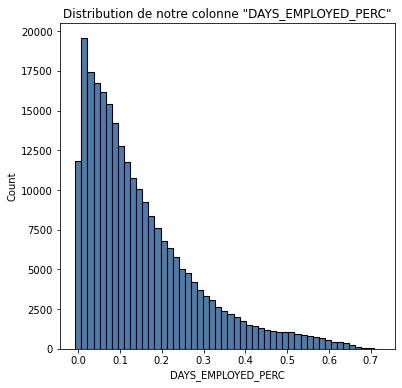

In [32]:
print('moyenne :', round(train_df['DAYS_EMPLOYED_PERC'].mean(), 2))
print('médiane :', round(train_df['DAYS_EMPLOYED_PERC'].median(), 2))
print('mode :', train_df['DAYS_EMPLOYED_PERC'].mode())

# Histrogramme de la distribution de la variable
plt.figure(figsize = (6, 6))
plt.hist(x = train_df['DAYS_EMPLOYED_PERC'].values, bins = 50, align = 'left', color = '#4d7cab',
         edgecolor = 'black', linewidth = 1.1)
plt.title('Distribution de notre colonne "DAYS_EMPLOYED_PERC"')
plt.xlabel('DAYS_EMPLOYED_PERC')
plt.ylabel('Count')
plt.show()

In [33]:
cols_to_fill_bis = ['DAYS_EMPLOYED_PERC', 'DAYS_EMPLOYED']

for col in cols_to_fill_bis:
    train_df[col].fillna(train_df[col].median(), inplace = True)
    test_df[col].fillna(test_df[col].median(), inplace = True)

In [34]:
# On regarde l'équilibre de nos classes
train_df['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [44]:
import time

In [51]:
# Standard Scaler ???

In [52]:
# Class imbalance (class weight ou SMOTE)

In [53]:
# t0 = time.time()
# # Divide in training/validation and test data
# print("Starting LogicticRegression. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

# # Cross validation model
# # if stratified:
# #     folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=24)
# # else:
# folds = KFold(n_splits= 10, shuffle=True, random_state=24)
    
# # Create arrays and dataframes to store results
# oof_preds = np.zeros(train_df.shape[0])
# sub_preds = np.zeros(test_df.shape[0])
# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# X = train_df.drop('TARGET', axis = 1)
# y = train_df['TARGET']

# clf = LogisticRegression(class_weight={0:1, 1:5}, random_state=24)

# clf.fit(X, y)

# y_proba_pred = clf.predict_proba(test_df.drop('TARGET', axis = 1))
# y_pred = clf.predict(test_df.drop('TARGET', axis = 1))
# t1 = time.time()
# time_round = np.round(t1 - t0, 2)
# print(f'Time : {time_round} secondes')

## Corrélations

In [36]:
df.shape

(356251, 603)

In [48]:
train_df['CC_NAME_CONTRACT_STATUS_nan_MAX']

KeyError: 'CC_NAME_CONTRACT_STATUS_nan_MAX'

In [37]:
df_corr = df.copy()

In [91]:
df_corr.corr()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
index,1.000000,0.837311,-0.002114,-0.003517,0.002091,-0.001558,-0.008583,0.033421,-0.025803,-0.000021,...,0.004458,0.000784,0.006472,0.001555,NaN,NaN,NaN,NaN,NaN,0.000421
SK_ID_CURR,0.837311,1.000000,-0.002111,0.000752,0.001551,0.000336,-0.001606,0.000417,0.000623,-0.000976,...,-0.005560,-0.006409,-0.001296,-0.006443,NaN,NaN,NaN,NaN,NaN,-0.000617
TARGET,-0.002114,-0.002111,1.000000,-0.054710,-0.021850,0.006146,-0.003982,-0.030371,-0.012818,0.078242,...,-0.008871,0.000570,-0.006201,-0.001613,NaN,NaN,NaN,NaN,NaN,-0.060481
CODE_GENDER,-0.003517,0.000752,-0.054710,1.000000,-0.343445,-0.041584,-0.078534,-0.016903,-0.076724,-0.151347,...,0.003723,0.002509,0.006601,0.002405,NaN,NaN,NaN,NaN,NaN,0.000054
FLAG_OWN_CAR,0.002091,0.001551,-0.021850,-0.343445,1.000000,0.002095,0.089026,0.116993,0.143514,0.130522,...,0.003321,0.002312,0.004528,-0.002301,NaN,NaN,NaN,NaN,NaN,0.041347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC_NAME_CONTRACT_STATUS_nan_MAX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_NAME_CONTRACT_STATUS_nan_MEAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_NAME_CONTRACT_STATUS_nan_SUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_NAME_CONTRACT_STATUS_nan_VAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Graphiquement avec une heatmap :
h = sns.heatmap(df_corr.corr(), linewidth = 0.5, cmap = "coolwarm")

In [46]:
from sklearn.metrics import roc_auc_score

In [42]:
from sklearn.model_selection import StratifiedKFold

X = train_df.drop('TARGET', axis = 1)
y = train_df['TARGET']
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
cv = folds.split(X, y)
cv = list(cv)

In [47]:
t0 = time.time()

oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# On sépare notre train en train et validation
for n_fold, (train_idx, valid_idx) in enumerate(cv):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    
    clf = LogisticRegression(class_weight={0:1, 1:5}, random_state=24)
    clf.fit(train_x, train_y)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    
    feature_importances = []
    for _, v in enumerate(clf.coef_[0]):
        feature_importances.append(v)
    
    fold_importance_df["importance"] = feature_importances
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

t1 = time.time()
time_round = np.round(t0 - t1, 2)
print(f'Time : {time_round} secondes')

Fold  1 AUC : 0.607353
Fold  2 AUC : 0.605558
Fold  3 AUC : 0.603728
Fold  4 AUC : 0.607800
Fold  5 AUC : 0.602450


NameError: name 't1' is not defined

In [44]:
# On met nos scores dans le bon DF et on calcule accuracy pour voir ce que ça donne
# Voir la confusion matrix

In [ ]:
# Mettre d'autres metrics

In [60]:
y_pred_train = clf.predict(train_df.drop('TARGET', axis = 1))

In [61]:
accuracy_score(y, y_pred_train)

0.9192701304360551

In [ ]:
df_try = train_df